# Linear Regression Analysis: Sentencing Disparities in California

**Objective**: Develop a multiple linear regression model to analyze factors affecting sentence length

**Dependent Variable**: Aggregate sentence in months (CURRENT sentence)

**Independent Variables** (dummy coded):

*From Current Offense (demographics.csv):*
- Ethnicity
- Sentencing County
- Current Offense Category
- Sentence Type

*From Prior Criminal History (prior_commitments.csv):*
- Number of prior commitments
- Number of priors committed while in prison
- Most common prior offense category
- Most common relationship type (how priors relate to current case)

## 1. Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 2. Load Data

In [26]:
# Local file path on Windows (using forward slashes - works on Windows!)
local_data_path = 'C:/Users/gandh/Desktop/Viraj/UC Davis MSBA Program/Practicum/Datasets'

# Load demographics dataset
demographics = pd.read_csv(local_data_path + '/demographics.csv')

# Load prior commitments dataset
prior_commitments = pd.read_csv(local_data_path + '/prior_commitments.csv')

## 3. Process Prior Commitments Data

Transform prior criminal history from multiple rows per person to summary statistics at the individual level.

In [27]:
# Create in_prison indicator: if 'in prison' column has a value, offense occurred in prison
prior_commitments['offense_in_prison'] = prior_commitments['in prison'].notna().astype(int)

# Aggregate prior commitments to individual level (one row per cdcno)
prior_agg = prior_commitments.groupby('cdcno').agg({
    'case number': 'count',  # Total number of prior commitments
    'offense_in_prison': 'sum',  # Count of priors committed in prison
    'offense category': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',  # Most common prior offense
    'relationship': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'  # Most common relationship type
}).reset_index()

prior_agg.columns = ['cdcno', 'num_prior_commitments', 'num_priors_in_prison', 
                     'most_common_prior_offense', 'most_common_relationship']

## 4. Merge Datasets

Combine CURRENT offense data (demographics) with PRIOR criminal history summaries.

In [28]:
# Merge demographics with aggregated prior commitments (left join to keep all defendants)
merged_data = demographics.merge(prior_agg, on='cdcno', how='left')

# Fill missing values for defendants with no prior commitments
merged_data['num_prior_commitments'] = merged_data['num_prior_commitments'].fillna(0)
merged_data['num_priors_in_prison'] = merged_data['num_priors_in_prison'].fillna(0)
merged_data['most_common_prior_offense'] = merged_data['most_common_prior_offense'].fillna('None')
merged_data['most_common_relationship'] = merged_data['most_common_relationship'].fillna('None')

## 5. Data Cleaning

In [29]:
# Define key columns for regression
key_columns = ['aggregate sentence in months', 'ethnicity', 'controlling case sentencing county',
               'offense category', 'sentence type']

# Remove rows with missing values in key columns
regression_data = merged_data.dropna(subset=key_columns).copy()

# Remove non-positive sentence lengths
regression_data = regression_data[regression_data['aggregate sentence in months'] > 0]

# Define key columns for regression
key_columns = ['aggregate sentence in months', 'ethnicity', 'controlling case sentencing county',
               'offense category', 'sentence type']

# Remove rows with missing values in key columns
regression_data = merged_data.dropna(subset=key_columns).copy()

# Remove non-positive sentence lengths
regression_data = regression_data[regression_data['aggregate sentence in months'] > 0]

# Cap at 90 years (1080 months) - very thorough maximum
cap_value = 1080
print(f"Capping sentence length at {cap_value} months ({cap_value/12:.0f} years)")

# Count how many will be capped
num_capped = (regression_data['aggregate sentence in months'] > cap_value).sum()
print(f"Sentences that will be capped: {num_capped} ({num_capped/len(regression_data)*100:.2f}%)")

# Apply cap
regression_data['aggregate sentence in months'] = regression_data['aggregate sentence in months'].clip(upper=cap_value)

print(f"\nDataset size: {len(regression_data)}")
print(f"\nNew sentence length statistics:")
print(regression_data['aggregate sentence in months'].describe())

Capping sentence length at 1080 months (90 years)
Sentences that will be capped: 9802 (10.27%)

Dataset size: 95474

New sentence length statistics:
count    95474.000000
mean       332.980131
std        325.202295
min          8.000000
25%         88.000000
50%        216.000000
75%        420.000000
max       1080.000000
Name: aggregate sentence in months, dtype: float64


## 6. Create Dummy Variables

In [30]:
# List categorical variables to convert to dummy variables
categorical_vars = [
    # CURRENT offense characteristics (from demographics)
    'ethnicity',
    'controlling case sentencing county',
    'offense category',
    'sentence type',
    # PRIOR criminal history characteristics (aggregated from prior_commitments)
    'most_common_prior_offense',
    'most_common_relationship'
]

# Create dummy variables (drop_first=True to avoid multicollinearity)
regression_dummies = pd.get_dummies(regression_data[categorical_vars], 
                                    drop_first=True, 
                                    dtype=int)

## 7. Prepare Feature Matrix and Target Variable

In [31]:
# Add continuous variables from PRIOR criminal history
continuous_vars = ['num_prior_commitments', 'num_priors_in_prison']

# Combine dummy variables with continuous variables to create feature matrix
X = pd.concat([regression_dummies, regression_data[continuous_vars].reset_index(drop=True)], axis=1)

# Extract dependent variable: CURRENT sentence length in months
y = regression_data['aggregate sentence in months'].reset_index(drop=True)

# Check for missing or infinite values before fitting model
print(f"Missing values in X: {X.isna().sum().sum()}")
print(f"Infinite values in X: {np.isinf(X.select_dtypes(include=[np.number])).sum().sum()}")
print(f"Missing values in y: {y.isna().sum()}")
print(f"Infinite values in y: {np.isinf(y).sum()}")

Missing values in X: 204
Infinite values in X: 0
Missing values in y: 0
Infinite values in y: 0


### Clean Data Issues

In [32]:
# Remove rows with NaN or infinite values
# Create boolean mask for valid rows
valid_X_rows = ~(X.isna().any(axis=1) | np.isinf(X.select_dtypes(include=[np.number])).any(axis=1))
valid_y_rows = ~(y.isna() | np.isinf(y))
valid_rows = valid_X_rows & valid_y_rows

# Filter both X and y
X_clean = X[valid_rows].copy()
y_clean = y[valid_rows].copy()

print(f"\nOriginal dataset size: {len(X)}")
print(f"Cleaned dataset size: {len(X_clean)}")
print(f"Rows removed: {len(X) - len(X_clean)}")

# Add constant term (intercept) to the cleaned model
X_with_const = sm.add_constant(X_clean)

correlations = pd.DataFrame({
    'Variable': X_clean.columns,
    'Correlation_with_Sentence': [X_clean[col].corr(y_clean) for col in X_clean.columns]
})
correlations['Abs_Correlation'] = correlations['Correlation_with_Sentence'].abs()
correlations = correlations.sort_values('Abs_Correlation', ascending=False)

print("Top 20 predictors most correlated with sentence length:")
print(correlations.head(20))

# Check for perfect or near-perfect correlations (> 0.99)
perfect_corr = correlations[correlations['Abs_Correlation'] > 0.99]
if len(perfect_corr) > 0:
    print("\n*** PROBLEM FOUND: Variables with near-perfect correlation ***")
    print(perfect_corr)
else:
    print("\nNo perfect correlations found in individual variables")

# Check if continuous variables have extreme values
print("\nContinuous variable statistics:")
print(regression_data[continuous_vars].describe())

# Check for issues in the dependent variable
print("\nDependent variable (sentence length) statistics:")
print(y_clean.describe())
print(f"\nUnique values in sentence length: {y_clean.nunique()}")


# Check the actual column names to see if something suspicious is included
print("\nAll feature names in the model:")
print(X_clean.columns.tolist())



Original dataset size: 95476
Cleaned dataset size: 95472
Rows removed: 4
Top 20 predictors most correlated with sentence length:
                                           Variable  \
87                    sentence type_Life w/o Parole   
86                                sentence type_DSL   
88                   sentence type_Life with Parole   
89                     sentence type_Second Striker   
84                    offense category_Other Crimes   
9                                ethnicity_Hispanic   
85                 offense category_Property Crimes   
90                      sentence type_Third Striker   
15                                ethnicity_Mexican   
83                     offense category_Drug Crimes   
100                           num_prior_commitments   
43   controlling case sentencing county_Los Angeles   
0                                   ethnicity_Black   
98                    most_common_relationship_None   
93                   most_common_prior_offens

## 8. Fit Linear Regression Model

In [33]:
# Fit OLS regression model using cleaned data
model = sm.OLS(y_clean, X_with_const)
results = model.fit()

## 9. Model Summary

In [34]:
# Display full regression results
print(results.summary())

                                 OLS Regression Results                                 
Dep. Variable:     aggregate sentence in months   R-squared:                       0.631
Model:                                      OLS   Adj. R-squared:                  0.630
Method:                           Least Squares   F-statistic:                     1613.
Date:                          Sun, 18 Jan 2026   Prob (F-statistic):               0.00
Time:                                  23:31:42   Log-Likelihood:            -6.4016e+05
No. Observations:                         95472   AIC:                         1.281e+06
Df Residuals:                             95370   BIC:                         1.281e+06
Df Model:                                   101                                         
Covariance Type:                      nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025    

## 10. Extract and Analyze Key Coefficients

### 10.1 Ethnicity Effects

In [35]:
# Extract ethnicity coefficients
ethnicity_coefs = results.params[results.params.index.str.contains('ethnicity')]
ethnicity_pvalues = results.pvalues[results.pvalues.index.str.contains('ethnicity')]
ethnicity_ci = results.conf_int()[results.conf_int().index.str.contains('ethnicity')]

ethnicity_summary = pd.DataFrame({
    'Coefficient': ethnicity_coefs,
    'P-value': ethnicity_pvalues,
    'CI_Lower': ethnicity_ci[0],
    'CI_Upper': ethnicity_ci[1],
    'Significant': ethnicity_pvalues < 0.05
}).sort_values('Coefficient', ascending=False)

ethnicity_summary

,Coefficient,P-value,CI_Lower,CI_Upper,Significant
ethnicity_Nicaraguan,167.990436,0.016692,30.424988,305.555885,True
ethnicity_Japanese,61.298230,0.233368,-39.516066,162.112526,False
ethnicity_Salvadorian,40.673886,0.074860,-4.079120,85.426892,False
ethnicity_Korean,36.920445,0.246987,-25.585589,99.426478,False
ethnicity_Puerto Rican,35.683386,0.192318,-17.960650,89.327422,False
ethnicity_Guamanian,34.967663,0.482832,-62.696109,132.631436,False
ethnicity_Guatemalan,33.804487,0.277624,-27.223118,94.832093,False
ethnicity_Columbian,33.785079,0.676498,-124.917424,192.487582,False
ethnicity_Cambodian,24.517592,0.354737,-27.407947,76.443130,False
ethnicity_Mexican,19.333594,0.002618,6.742168,31.925021,True


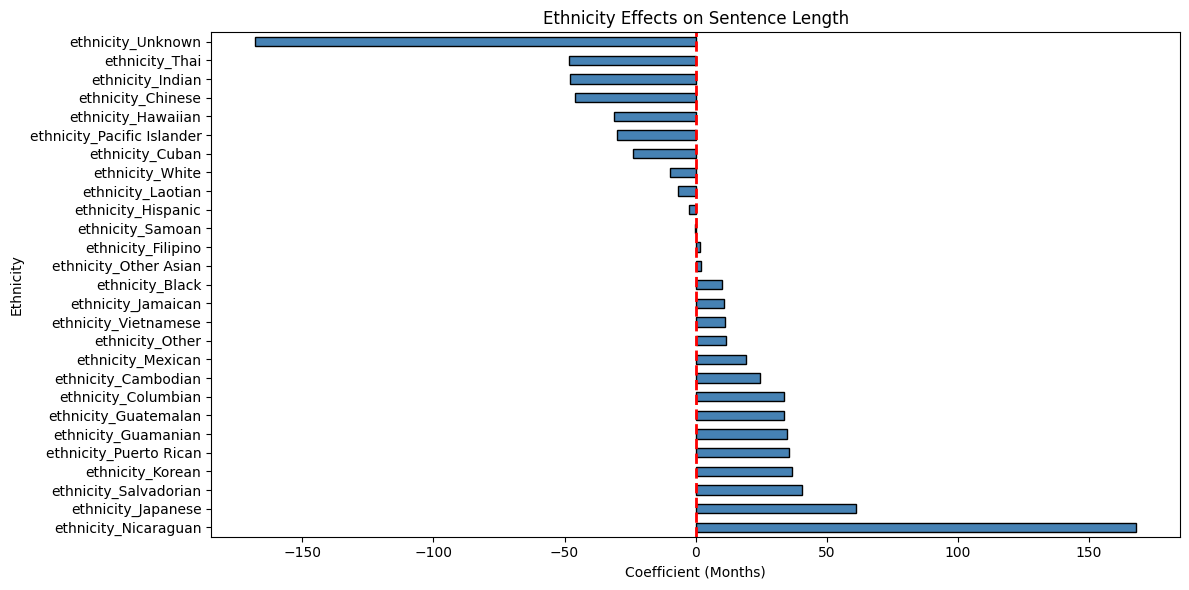

In [36]:
# Visualize ethnicity effects
plt.figure(figsize=(12, 6))
ethnicity_summary['Coefficient'].plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('Coefficient (Months)')
plt.ylabel('Ethnicity')
plt.title('Ethnicity Effects on Sentence Length')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()

### 10.2 Offense Category Effects

In [37]:
# Extract offense category coefficients
offense_coefs = results.params[results.params.index.str.contains('offense category')]
offense_pvalues = results.pvalues[results.pvalues.index.str.contains('offense category')]

offense_summary = pd.DataFrame({
    'Coefficient': offense_coefs,
    'P-value': offense_pvalues,
    'Significant': offense_pvalues < 0.05
}).sort_values('Coefficient', ascending=False)

offense_summary

,Coefficient,P-value,Significant
offense category_Property Crimes,-101.757563,4.826847e-308,True
offense category_Other Crimes,-115.345812,0.000000e+00,True
offense category_Drug Crimes,-115.975281,2.941319e-167,True


### 10.3 Sentence Type Effects

In [38]:
# Extract sentence type coefficients
sentence_type_coefs = results.params[results.params.index.str.contains('sentence type')]
sentence_type_pvalues = results.pvalues[results.pvalues.index.str.contains('sentence type')]

sentence_type_summary = pd.DataFrame({
    'Coefficient': sentence_type_coefs,
    'P-value': sentence_type_pvalues,
    'Significant': sentence_type_pvalues < 0.05
}).sort_values('Coefficient', ascending=False)

sentence_type_summary

,Coefficient,P-value,Significant
sentence type_Life w/o Parole,-1.140016,0.889846,False
sentence type_Third Striker,-511.710085,0.000000,True
sentence type_Life with Parole,-563.910205,0.000000,True
sentence type_Second Striker,-871.450831,0.000000,True
sentence type_DSL,-895.767606,0.000000,True


### 10.4 Prior Commitment Effects

In [39]:
# Extract relationship coefficients
relationship_coefs = results.params[results.params.index.str.contains('most_common_relationship')]
relationship_pvalues = results.pvalues[results.pvalues.index.str.contains('most_common_relationship')]

relationship_summary = pd.DataFrame({
    'Coefficient': relationship_coefs,
    'P-value': relationship_pvalues,
    'Significant': relationship_pvalues < 0.05
}).sort_values('Coefficient', ascending=False)

relationship_summary

,Coefficient,P-value,Significant
most_common_relationship_None,7.118567e+13,1.638796e-01,False
most_common_relationship_Stayed,1.087725e+01,1.941066e-01,False
most_common_relationship_Consecutive,-1.945204e+00,5.051389e-01,False
most_common_relationship_Initial,-2.430915e+01,6.554334e-28,True


In [40]:
# Extract continuous prior commitment variables
prior_vars = ['num_prior_commitments', 'num_priors_in_prison']

prior_continuous_summary = pd.DataFrame({
    'Coefficient': [results.params[var] for var in prior_vars],
    'P-value': [results.pvalues[var] for var in prior_vars],
    'Significant': [results.pvalues[var] < 0.05 for var in prior_vars]
}, index=prior_vars)

prior_continuous_summary

,Coefficient,P-value,Significant
num_prior_commitments,-3.225628,1.148773e-39,True
num_priors_in_prison,2.706010,2.998455e-01,False


## 11. Model Diagnostics

### 11.1 Residual Plots

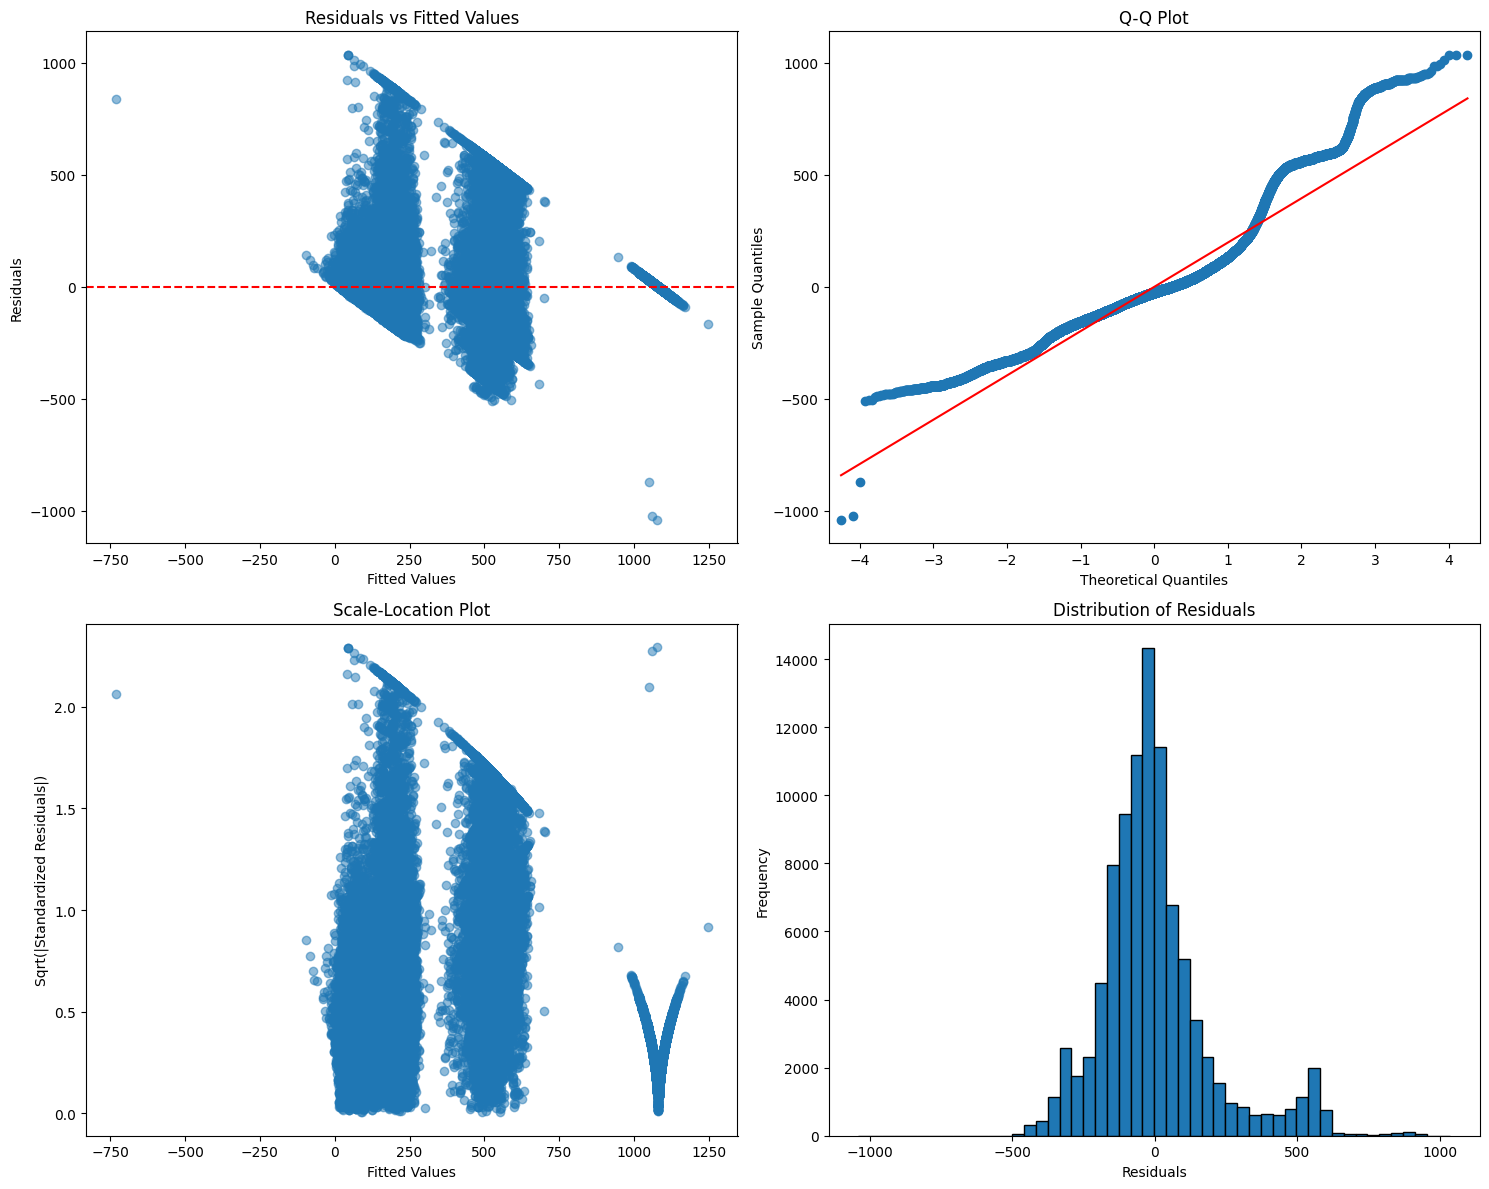

In [41]:
# Calculate predictions and residuals
predictions = results.predict(X_with_const)
residuals = results.resid

# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Residuals vs Fitted
axes[0, 0].scatter(predictions, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values')

# Q-Q Plot
sm.qqplot(residuals, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot')

# Scale-Location Plot
standardized_residuals = np.sqrt(np.abs((residuals - residuals.mean()) / residuals.std()))
axes[1, 0].scatter(predictions, standardized_residuals, alpha=0.5)
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('Sqrt(|Standardized Residuals|)')
axes[1, 0].set_title('Scale-Location Plot')

# Histogram of Residuals
axes[1, 1].hist(residuals, bins=50, edgecolor='black')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

### 11.2 Multicollinearity Check (VIF)

In [42]:
# Calculate VIF for continuous variables and sample of categorical
# Note: VIF calculation can be slow with many dummy variables

# Select continuous variables and a few ethnicity dummies for VIF check
vif_vars = continuous_vars + [col for col in X_clean.columns if 'ethnicity' in col][:5]

vif_data = pd.DataFrame()
vif_data['Variable'] = vif_vars
vif_data['VIF'] = [variance_inflation_factor(X_clean[vif_vars].values, i) 
                   for i in range(len(vif_vars))]

vif_data.sort_values('VIF', ascending=False)

,Variable,VIF
0,num_prior_commitments,1.114738
2,ethnicity_Black,1.072596
1,num_priors_in_prison,1.046874
6,ethnicity_Cuban,1.000159
3,ethnicity_Cambodian,1.000141
4,ethnicity_Chinese,1.000023
5,ethnicity_Columbian,1.000000


## 12. Complete Results Table

In [43]:
# Create comprehensive results dataframe
results_df = pd.DataFrame({
    'Variable': results.params.index,
    'Coefficient': results.params.values,
    'Std_Error': results.bse.values,
    'T_Statistic': results.tvalues.values,
    'P_Value': results.pvalues.values,
    'CI_Lower': results.conf_int()[0].values,
    'CI_Upper': results.conf_int()[1].values
})

# Add significance indicators
results_df['Significant_001'] = results_df['P_Value'] < 0.001
results_df['Significant_01'] = results_df['P_Value'] < 0.01
results_df['Significant_05'] = results_df['P_Value'] < 0.05

# Sort by absolute coefficient value
results_df['Abs_Coefficient'] = results_df['Coefficient'].abs()
results_df = results_df.sort_values('Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1)

results_df.head(30)

,Variable,Coefficient,Std_Error,T_Statistic,P_Value,CI_Lower,CI_Upper,Significant_001,Significant_01,Significant_05
94,most_common_prior_offense_None,-7.118567e+13,5.113355e+13,-1.392152,1.638796e-01,-1.714069e+14,2.903552e+13,False,False,False
99,most_common_relationship_None,7.118567e+13,5.113355e+13,1.392152,1.638796e-01,-2.903552e+13,1.714069e+14,False,False,False
0,const,1.112183e+03,1.158516e+01,96.000637,0.000000e+00,1.089476e+03,1.134889e+03,True,True,True
87,sentence type_DSL,-8.957676e+02,7.868840e+00,-113.837308,0.000000e+00,-9.111904e+02,-8.803448e+02,True,True,True
90,sentence type_Second Striker,-8.714508e+02,7.944884e+00,-109.687039,0.000000e+00,-8.870227e+02,-8.558789e+02,True,True,True
89,sentence type_Life with Parole,-5.639102e+02,7.870031e+00,-71.652854,0.000000e+00,-5.793354e+02,-5.484850e+02,True,True,True
91,sentence type_Third Striker,-5.117101e+02,8.327270e+00,-61.449922,0.000000e+00,-5.280314e+02,-4.953887e+02,True,True,True
25,ethnicity_Unknown,-1.680226e+02,1.978778e+02,-0.849123,3.958150e-01,-5.558609e+02,2.198157e+02,False,False,False
17,ethnicity_Nicaraguan,1.679904e+02,7.018685e+01,2.393474,1.669157e-02,3.042499e+01,3.055559e+02,False,False,True
84,offense category_Drug Crimes,-1.159753e+02,4.198980e+00,-27.619870,2.941319e-167,-1.242052e+02,-1.077453e+02,True,True,True


## 13. Save Results

In [45]:
# Save complete results to CSV
results_df.to_csv(local_data_path + '/results.csv', index=False)